# Fourier filter vs explicit form for time series

Two realizations

 - REAL array FFT: Using `np.fft.ifft` means that if one only picks up the positive frequency corresponding to the frequency to be filtered, then one has to **multiply by 2**.
 - Fourier extrapolation: Does not do well for small number of wavelengths. Fourier filter does better.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Fourier extrapolation as a prediction tool

https://www.kdnuggets.com/2016/11/combining-different-methods-create-advanced-time-series-prediction.html

In [2]:
def fourierExtrapolation(x, n_predict=12, n_harmonics=12):
    # x = input series
    # n_predict = number of time snapshots for prediction
    # n_harmonics = number of fourier frequencies to keep
    n = x.size
    x_f = np.fft.fft(x)
    f = np.fft.fftfreq(n)
    #idx = np.arange(n)
    #idx.sort(lambda i: np.abs(f[i]))
    idx = np.argsort(np.abs(f))
    t_arr = np.arange(0, n + n_predict)
    forecast = np.zeros(t_arr.size)
    
    for j in idx[:1 + 2*n_harmonics]:
        ampl  = np.abs(x_f[j])/n # amplitude
        phase = np.angle(x_f[j]) # phase
        forecast += ampl * np.cos(2*np.pi*f[j]*t_arr + phase)
        
    return forecast

## Dummy data

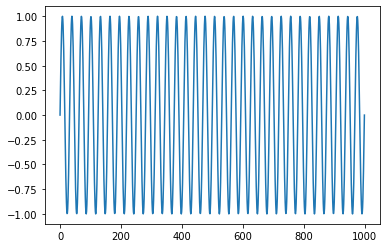

In [17]:
# 2 full sinusoid wavelengths with an array of 1000 points
n_wavelengths = 32
t_length = 1000
dummy_series = np.sin(2*np.pi/32 * np.linspace(0,
                                               32*n_wavelengths,
                                               t_length))
plt.plot(dummy_series)

## TEST 

If the function is written correctly, it should correctly predict the sine series

**NOTE**: If the `n_wavelengths=2`, the fourier Extrapolation will be terrible as I think the fft picks up noise.

## Method 1: Fourier extrapolation above

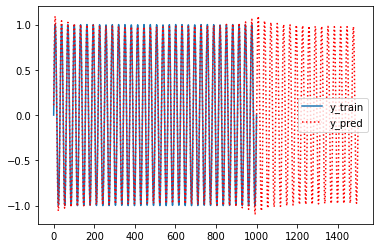

In [18]:
# For n_wavelengths = 2
# 500 points = 1 wavelength
# Prediction for the next 500 points should yield a perfect full wavelength
y_pred = fourierExtrapolation(dummy_series, 
                              n_predict=500, 
                              n_harmonics=n_wavelengths)
plt.plot(dummy_series, label='y_train')
plt.plot(y_pred, 'r:', label='y_pred')
plt.legend()

(1000,)


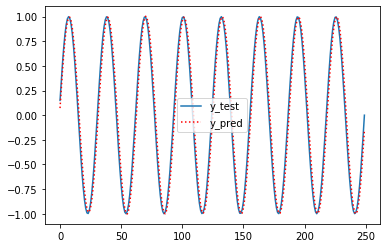

In [19]:
# Less number of points should yield an incomplete wave

y_train = dummy_series[:-250]
y_test  = dummy_series[-250:]

# 500 points = 1 wavelength
# Prediction for the next 500 points should yield a perfect full wavelength
y_pred = fourierExtrapolation(y_train, 
                              n_predict=250, 
                              n_harmonics=n_wavelengths)

print(y_pred.shape)

plt.plot(y_test, label='y_test')
plt.plot(y_pred[-250:], 'r:', label='y_pred')
plt.legend()

## Method 2: Fourier filtering

Amplitude returned is **divided by 2** for real signals. Basically need to add both the positive and negative frequencies, which for a real signal are equal. See the answer here:

https://www.mathworks.com/matlabcentral/answers/84141-why-fft-function-returns-amplitude-divided-by-2

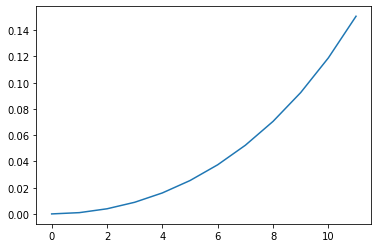

In [20]:
x_f = np.fft.fft(dummy_series)
#plt.plot(np.abs(x_f)[:t_length//2]**2)
plt.plot(np.abs(x_f)[:12]**2)

In [21]:
print(np.abs(x_f[n_wavelengths-1:n_wavelengths+1])**2)
print(np.abs(x_f[-n_wavelengths:-n_wavelengths+2])**2)

[2.32179316e+02 2.48906338e+05]
[2.48906338e+05 2.32179316e+02]


In [22]:
dum_f = np.zeros_like(x_f)

dum_f[n_wavelengths] = 2*x_f[n_wavelengths]

# Should be (otherwise multiply by 2)
#dum_f[16] = x_f[16] + x_f[-16]

x_f_f = np.fft.ifft(dum_f)

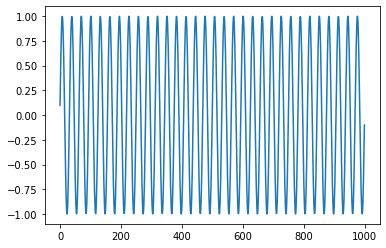

In [23]:
plt.plot(x_f_f.real)

## METRICS

In [24]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error

In [25]:
def mean_absolute_percentage_error(y_true, y_pred, eps = 1e-3): 
    # Avoid values too close to zero
    idxs = np.abs(y_true) > eps
    return np.mean(np.abs((y_true[idxs] - y_pred[idxs]) / y_true[idxs])) * 100 
#if y_true != 0 else 0.0

In [26]:
# Method 1:
y_pred1 = y_pred[-250:]

# Method 2:
y_pred2 = x_f_f[-250:].real

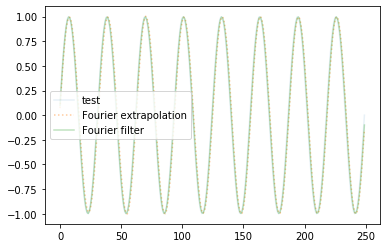

In [27]:
plt.plot(y_test, label='test', alpha=0.1)
plt.plot(y_pred1, ':', label='Fourier extrapolation', alpha=0.4)
plt.plot(y_pred2, '-', label='Fourier filter', alpha=0.3)
plt.legend()

In [28]:
print(r2_score(y_test, y_pred1))
print(r2_score(y_test, y_pred2))

0.9777387036884655
0.9940911237666009


In [29]:
[r2_score(y_test, y_pred_) for y_pred_ in [y_pred1,y_pred2]]

[0.9777387036884655, 0.9940911237666009]

In [30]:
[mean_squared_error(y_test, y_pred_) for y_pred_ in [y_pred1,y_pred2]]

[0.01111957397789895, 0.0029514986676443143]

In [31]:
[mean_absolute_error(y_test, y_pred_) for y_pred_ in [y_pred1,y_pred2]]

[0.0946734734827674, 0.04803296397941287]

In [32]:
[median_absolute_error(y_test, y_pred_) for y_pred_ in [y_pred1,y_pred2]]

[0.10351084600073074, 0.05014860761483303]

In [33]:
[mean_absolute_percentage_error(y_test, y_pred_, eps=1e-3) for y_pred_ in [y_pred1,y_pred2]]

[49.475244189420984, 24.858545318504994]

In [34]:
#np.abs(y_test) > 0.01